# Imports

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Conv2DTranspose, Cropping2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory

import os
from os import listdir
from os.path import isfile, join

import PIL

import matplotlib.pyplot as plt
import numpy as np

In [2]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [3]:
data_folder = "data/train_resized/"
label_folder = "data/train_masks_388/"

# Designing the model

In [4]:
def contractor(inputs, n_filters, cropping, layer_index):
    # Convolutes and maxpools
    outputs = Conv2D(n_filters, (3,3), activation="relu", name=f"l{layer_index}_1")(inputs)
    outputs = Conv2D(n_filters, (3,3), activation="relu", name=f"l{layer_index}_2")(outputs)
    pooled = MaxPool2D((2,2), name=f'l{layer_index}_maxpool')(outputs)
    
    # Crops and copies
    crop = Cropping2D(cropping)(outputs)
    
    return pooled, crop

In [5]:
def expansor(inputs, crop, n_filters, layer_index):
    # Concatenates
    if crop is not None:
        outputs = tf.concat((crop, inputs), axis=-1) # axis=-1 might not work
    else:
        outputs = inputs
    # Convolutes
    outputs = Conv2D(n_filters, (3,3), activation='relu', name=f"l{layer_index}_1")(outputs)
    outputs = Conv2D(n_filters, (3,3), activation='relu', name=f"l{layer_index}_2")(outputs)
    
    # Transpose-convolutes
    return Conv2DTranspose(n_filters//2, 1, (2,2), name=f'l{layer_index}_upconv')(outputs)

In [6]:
def last_layer(inputs, crop, n_filters, layer_index):
    # Concatenates
    outputs = tf.concat((crop, inputs), axis=-1) # axis=-1 might not work

    # Convolutes
    outputs = Conv2D(n_filters, (3,3), activation='relu', name=f"l{layer_index}_1")(outputs)
    outputs = Conv2D(n_filters, (3,3), activation='relu', name=f"l{layer_index}_2")(outputs)
    
    # Convolutes 1x1
    return Conv2D(2, (1,1), name=f'l{layer_index}_conv1x1')(outputs)

In [7]:
def make_model():
    inputs = Input(shape=(572, 572, 1))
    
    n_filters = 64
    # Contaction
    x, crop1 = contractor(inputs, n_filters, 88, 1)
    x, crop2 = contractor(x, n_filters*2, 40, 2)
    x, crop3 = contractor(x, n_filters*4, 16, 3)
    x, crop4 = contractor(x, n_filters*8, 4, 4)
    
    # Expansion
    # Middle layers doesn't take any crop
    x = expansor(x, None, n_filters*16, 5)
    x = expansor(x, crop4, n_filters*8, 6)
    x = expansor(x, crop3, n_filters*4, 7)
    x = expansor(x, crop2, n_filters*2, 8)
    
    # Last layer
    x = last_layer(x, crop1, n_filters, 9)
    
    return Model(inputs, x, name="Unet")
    

In [8]:
model = make_model()

In [9]:
model.summary()

Model: "Unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 572, 572, 1) 0                                            
__________________________________________________________________________________________________
l1_1 (Conv2D)                   (None, 570, 570, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
l1_2 (Conv2D)                   (None, 568, 568, 64) 36928       l1_1[0][0]                       
__________________________________________________________________________________________________
l1_maxpool (MaxPooling2D)       (None, 284, 284, 64) 0           l1_2[0][0]                       
_______________________________________________________________________________________________

# Image pipeline

In [10]:
def get_merged_files(dir_):
    prev_prefix = None
    merged_list = []
    curr_list = []
    
    sub_lists = 0
    files = (dir_+f for f in listdir(dir_) if isfile(join(dir_, f)))
    for f in files:
        prefix = f.rsplit("_",1)[0]
        if  prefix != prev_prefix:
            merged_list.append(curr_list)
            prev_prefix = prefix
            curr_list = []
            sub_lists += 1
        curr_list.append(f)

    merged_list.append(curr_list)
    # Gets rid of the first necessary empty list.
    # Better than adding a " and if prev_prefix is not None" to the if
    return merged_list[1:]

In [11]:
merged_files = get_merged_files(data_folder)
merged_files[:3]

[['data/train_resized/000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0_blue.png',
  'data/train_resized/000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0_green.png',
  'data/train_resized/000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0_red.png',
  'data/train_resized/000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png'],
 ['data/train_resized/000a9596-bbc4-11e8-b2bc-ac1f6b6435d0_blue.png',
  'data/train_resized/000a9596-bbc4-11e8-b2bc-ac1f6b6435d0_green.png',
  'data/train_resized/000a9596-bbc4-11e8-b2bc-ac1f6b6435d0_red.png',
  'data/train_resized/000a9596-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png'],
 ['data/train_resized/000c99ba-bba4-11e8-b2b9-ac1f6b6435d0_blue.png',
  'data/train_resized/000c99ba-bba4-11e8-b2b9-ac1f6b6435d0_green.png',
  'data/train_resized/000c99ba-bba4-11e8-b2b9-ac1f6b6435d0_red.png',
  'data/train_resized/000c99ba-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png']]

In [12]:
def format_image_list(merged_files, chunk_size=1024):
    """
    Formats and filters the images (by chunks to avoid memory overflow) so they follow the pattern needed for cellsegmentator.pred_cells:
    _ microtubules (red = index 2)
    _ endoplasmic reticulum (yellow = index 3 )
    _ nuclei image (blue = index 0)
    """
    # return format : [ [[r_0, r_1, ..., r_n], [y_0, y_1, ..., y_n], [b_0, b_1, ..., b_n]], ..chunks] with n = chunk_size
    n = len(merged_files)//1024
    return [[list(a) for a in zip(*[[sublist[2], sublist[3], sublist[0]] for sublist in merged_files[i*chunk_size:(i+1)*chunk_size]])] for i in range(n+1)]

# Training the model

In [13]:
BATCH_SIZE = 8

In [14]:
formatted_list = format_image_list(merged_files, BATCH_SIZE)

In [15]:
X_batch = [np.array(PIL.Image.open(file_path)) for file_path in formatted_list[0][2]]

In [16]:
y_batch = [np.array(PIL.Image.open(label_folder+"nuclei/"+file_path))[:,:,[0,2]] for file_path in listdir(label_folder+"nuclei/")[:BATCH_SIZE]]

In [17]:
np.array(y_batch).shape

(8, 388, 388, 2)

In [18]:
model.compile(optimizer="Adam", loss="mse")

In [19]:

for epoch in EPOCHS:
    for i in range(len(formatted_list)):
        model.fit(np.array([np.array(PIL.Image.open(file_path)) for file_path in formatted_list[i][2]], dtype=float), 
              np.array([np.array(PIL.Image.open(label_folder+"nuclei/"+file_path))[:,:,[0,2]] for file_path in listdir(label_folder+"nuclei/")[i*BATCH_SIZE:(i+1)*BATCH_SIZE]], dtype=float))

Epoch 1/500
1/1 [==============================] - 13s 13s/step - loss: 32036.8164
Epoch 2/500
1/1 [==============================] - 0s 385ms/step - loss: 29878.0684
Epoch 3/500
1/1 [==============================] - 0s 374ms/step - loss: 990892480.0000
Epoch 4/500
1/1 [==============================] - 0s 392ms/step - loss: 26408.0547
Epoch 5/500
1/1 [==============================] - 0s 384ms/step - loss: 30958.3555
Epoch 6/500
1/1 [==============================] - 0s 393ms/step - loss: 31352.5137
Epoch 7/500
1/1 [==============================] - 0s 364ms/step - loss: 31595.1719
Epoch 8/500
1/1 [==============================] - 0s 363ms/step - loss: 31762.0703
Epoch 9/500
1/1 [==============================] - 0s 359ms/step - loss: 31880.5840
Epoch 10/500
1/1 [==============================] - 0s 393ms/step - loss: 31966.2832
Epoch 11/500
1/1 [==============================] - 0s 384ms/step - loss: 32027.1230
Epoch 12/500
1/1 [==============================] - 0s 390ms/step - los

1/1 [==============================] - 0s 374ms/step - loss: 8089.6812
Epoch 99/500
1/1 [==============================] - 0s 373ms/step - loss: 8081.1655
Epoch 100/500
1/1 [==============================] - 0s 442ms/step - loss: 8084.4409
Epoch 101/500
1/1 [==============================] - 0s 413ms/step - loss: 8088.7949
Epoch 102/500
1/1 [==============================] - 0s 401ms/step - loss: 8083.6035
Epoch 103/500
1/1 [==============================] - 0s 411ms/step - loss: 8078.5776
Epoch 104/500
1/1 [==============================] - 0s 408ms/step - loss: 8081.5186
Epoch 105/500
1/1 [==============================] - 0s 376ms/step - loss: 8083.6738
Epoch 106/500
1/1 [==============================] - 0s 372ms/step - loss: 8079.3774
Epoch 107/500
1/1 [==============================] - 0s 371ms/step - loss: 8076.5649
Epoch 108/500
1/1 [==============================] - 0s 368ms/step - loss: 8078.9023
Epoch 109/500
1/1 [==============================] - 0s 371ms/step - loss: 8079.

1/1 [==============================] - 0s 362ms/step - loss: 7447.9023
Epoch 291/500
1/1 [==============================] - 0s 362ms/step - loss: 7488.7158
Epoch 292/500
1/1 [==============================] - 0s 361ms/step - loss: 7395.8364
Epoch 293/500
1/1 [==============================] - 0s 359ms/step - loss: 7476.8262
Epoch 294/500
1/1 [==============================] - 0s 361ms/step - loss: 7443.7471
Epoch 295/500
1/1 [==============================] - 0s 364ms/step - loss: 7380.2896
Epoch 296/500
1/1 [==============================] - 0s 363ms/step - loss: 7467.5659
Epoch 297/500
1/1 [==============================] - 0s 366ms/step - loss: 7457.1343
Epoch 298/500
1/1 [==============================] - 0s 359ms/step - loss: 7369.6870
Epoch 299/500
1/1 [==============================] - 0s 361ms/step - loss: 7450.7124
Epoch 300/500
1/1 [==============================] - 0s 368ms/step - loss: 7439.1821
Epoch 301/500
1/1 [==============================] - 0s 365ms/step - loss: 7347

1/1 [==============================] - 0s 366ms/step - loss: 4943.8706
Epoch 483/500
1/1 [==============================] - 0s 365ms/step - loss: 4810.4404
Epoch 484/500
1/1 [==============================] - 0s 365ms/step - loss: 5027.3062
Epoch 485/500
1/1 [==============================] - 0s 365ms/step - loss: 6031.5610
Epoch 486/500
1/1 [==============================] - 0s 367ms/step - loss: 6395.4004
Epoch 487/500
1/1 [==============================] - 0s 361ms/step - loss: 6495.5718
Epoch 488/500
1/1 [==============================] - 0s 367ms/step - loss: 6607.2720
Epoch 489/500
1/1 [==============================] - 0s 366ms/step - loss: 6476.2222
Epoch 490/500
1/1 [==============================] - 0s 368ms/step - loss: 6732.8413
Epoch 491/500
1/1 [==============================] - 0s 365ms/step - loss: 6134.7002
Epoch 492/500
1/1 [==============================] - 0s 366ms/step - loss: 5792.0117
Epoch 493/500
1/1 [==============================] - 0s 368ms/step - loss: 5649

In [22]:
test_img = PIL.Image.open("data/train_resized/ce93e70a-bba6-11e8-b2ba-ac1f6b6435d0_blue.png")

In [24]:
pred = model.predict(np.array(test_img)[None, ...])

In [25]:
pred

array([[[[259.43842 ,  49.42882 ],
         [260.93707 ,  35.08013 ],
         [261.9863  ,  45.27056 ],
         ...,
         [245.76938 ,  34.05142 ],
         [242.72078 ,  42.226536],
         [237.3229  ,  32.209362]],

        [[254.64384 ,  43.14136 ],
         [258.79865 ,  41.006474],
         [252.69539 ,  40.88579 ],
         ...,
         [244.29462 ,  39.20726 ],
         [233.5751  ,  37.95514 ],
         [233.52957 ,  38.586163]],

        [[257.68756 ,  49.841877],
         [259.58252 ,  38.81241 ],
         [258.38693 ,  48.19135 ],
         ...,
         [243.29752 ,  37.226604],
         [238.45193 ,  44.918865],
         [234.11586 ,  39.855667]],

        ...,

        [[255.89502 ,  43.38319 ],
         [260.12796 ,  41.219032],
         [254.01123 ,  41.13537 ],
         ...,
         [264.23016 ,  63.3034  ],
         [255.78139 ,  56.17776 ],
         [260.7664  ,  71.02615 ]],

        [[258.6012  ,  49.99811 ],
         [260.71344 ,  38.981934],
         [25

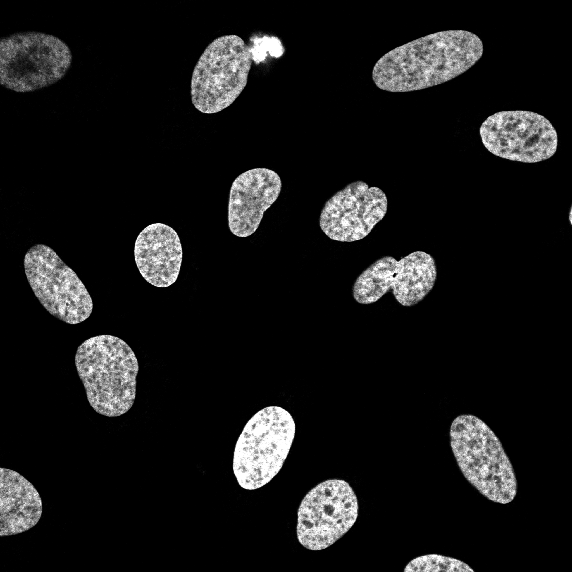

In [27]:
test_img

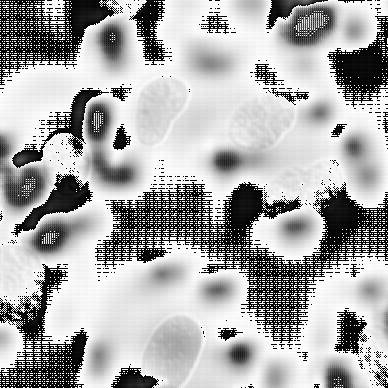

In [26]:
PIL.Image.fromarray(pred[0][..., 0].astype(np.uint8))